In [26]:
import xml.etree.ElementTree as ET
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt

In [27]:
xml_file = "O-A0038-003.xml"
tree = ET.parse(xml_file)
root = tree.getroot()
ns = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}

lon0 = float(root.find('.//cwa:BottomLeftLongitude', ns).text)
lat0 = float(root.find('.//cwa:BottomLeftLatitude', ns).text)

content_text = root.find('.//cwa:Content', ns).text.strip()
values = [float(v) for v in content_text.replace('\n', ',').split(',') if v.strip()]

cols, rows = 67, 120
grid = np.array(values).reshape(rows, cols)

#有效=1, 無效=0
label_grid = np.where(grid == -999.0, 0, 1)
value_grid = np.where(grid == -999.0, np.nan, grid)

lon = np.linspace(lon0, lon0 + (cols - 1) * 0.03, cols)
lat = np.linspace(lat0, lat0 + (rows - 1) * 0.03, rows)

In [28]:
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
lon_flat = lon_mesh.flatten()
lat_flat = lat_mesh.flatten()

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()

def norm_coords(lon_vals, lat_vals):
    lon_n = (lon_vals - lon_min) / (lon_max - lon_min)
    lat_n = (lat_vals - lat_min) / (lat_max - lat_min)
    return lon_n, lat_n

lon_norm, lat_norm = norm_coords(lon_flat, lat_flat)

In [29]:
class_tensor = torch.tensor(
    np.column_stack([lon_norm, lat_norm, label_grid.flatten()]),
    dtype=torch.float32
)

mask_valid = ~np.isnan(value_grid.flatten())
lon_norm_valid, lat_norm_valid = norm_coords(lon_flat[mask_valid], lat_flat[mask_valid])
reg_tensor = torch.tensor(
    np.column_stack([lon_norm_valid, lat_norm_valid,
                     value_grid.flatten()[mask_valid]]),
    dtype=torch.float32
)

In [30]:
def make_dataset(tensor, batch_size=64, split=0.8, target_index=-1):
    X = tensor[:, :2]
    y = tensor[:, target_index].unsqueeze(1)
    dataset = TensorDataset(X, y)
    n_train = int(len(dataset) * split)
    n_val = len(dataset) - n_train
    train_ds, val_ds = random_split(dataset, [n_train, n_val])
    return (DataLoader(train_ds, batch_size=batch_size, shuffle=True),
            DataLoader(val_ds, batch_size=batch_size))

class_train_loader, class_val_loader = make_dataset(class_tensor)
reg_train_loader,  reg_val_loader   = make_dataset(reg_tensor)

In [31]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 32), nn.Tanh(),
            nn.Linear(32, 8), nn.Tanh(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)
    
reg_model = Regressor()

In [32]:
def train_regression_model(model, train_loader, val_loader, epochs=4000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        t_loss = 0
        for X, y in train_loader:
            pred = model(X)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
        train_losses.append(t_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            v_loss = sum(criterion(model(Xv), yv).item() for Xv, yv in val_loader) / len(val_loader)
        val_losses.append(v_loss)

        if epoch % 100 == 0:
            print(f"[Epoch {epoch:03d}] "
                  f"Reg Train={train_losses[-1]:.4f} | Reg Val={v_loss:.4f}")

    return train_losses, val_losses

reg_train_losses, reg_val_losses = train_regression_model(
    reg_model, reg_train_loader, reg_val_loader, epochs=4000
)


[Epoch 100] Reg Train=37.0008 | Reg Val=40.7730
[Epoch 200] Reg Train=37.0563 | Reg Val=40.7496
[Epoch 300] Reg Train=36.9355 | Reg Val=40.7494
[Epoch 400] Reg Train=7.6840 | Reg Val=8.0653
[Epoch 500] Reg Train=7.3080 | Reg Val=7.5552
[Epoch 600] Reg Train=6.9559 | Reg Val=7.4199
[Epoch 700] Reg Train=6.8270 | Reg Val=7.3938
[Epoch 800] Reg Train=6.4481 | Reg Val=7.3110
[Epoch 900] Reg Train=6.3619 | Reg Val=6.9793
[Epoch 1000] Reg Train=6.3718 | Reg Val=7.2363
[Epoch 1100] Reg Train=6.1701 | Reg Val=7.0281
[Epoch 1200] Reg Train=6.1341 | Reg Val=7.1002
[Epoch 1300] Reg Train=6.0004 | Reg Val=7.0093
[Epoch 1400] Reg Train=5.9249 | Reg Val=6.8895
[Epoch 1500] Reg Train=5.7922 | Reg Val=6.7894
[Epoch 1600] Reg Train=5.6603 | Reg Val=6.9091
[Epoch 1700] Reg Train=5.7021 | Reg Val=7.1079
[Epoch 1800] Reg Train=5.5821 | Reg Val=6.9976
[Epoch 1900] Reg Train=5.4315 | Reg Val=6.7789
[Epoch 2000] Reg Train=5.4729 | Reg Val=6.4418
[Epoch 2100] Reg Train=5.2513 | Reg Val=6.6349
[Epoch 2200] Reg

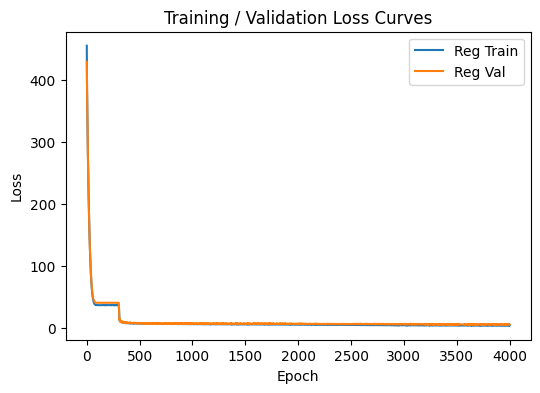

In [33]:
plt.figure(figsize=(6,4))
plt.plot(reg_train_losses, label='Reg Train')
plt.plot(reg_val_losses, label='Reg Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation Loss Curves")
plt.legend()
plt.show()

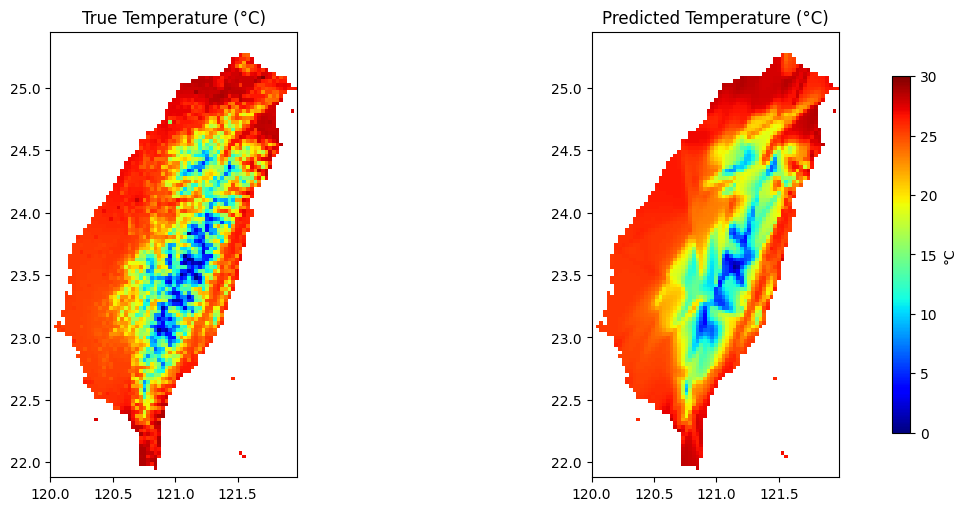

In [34]:
coords = torch.tensor(np.column_stack([lon_norm, lat_norm]), dtype=torch.float32)
reg_model.eval()
with torch.no_grad():
    pred_value = reg_model(coords).squeeze()

pred_grid = pred_value.numpy().reshape(rows, cols)

mask = label_grid.astype(bool)
pred_masked = np.where(mask, pred_grid, np.nan)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

im0 = axes[0].imshow(value_grid, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                     origin='lower', cmap='jet', vmin=0, vmax=30)
axes[0].set_title("True Temperature (°C)")

im1 = axes[1].imshow(pred_masked, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                     origin='lower', cmap='jet', vmin=0, vmax=30)
axes[1].set_title("Predicted Temperature (°C)")

cbar = fig.colorbar(im1, ax=axes, location="right", shrink=0.8)
cbar.set_label("°C")

plt.show()
